<a href="https://www.kaggle.com/code/ahmed3okka/pg-s4-e9-automl-submission?scriptVersionId=196095689" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression of Used Car Prices- Kaggle Playground Series 2024

## Overview

This notebook is part of the 2024 Kaggle Playground Series. The goal of the competition is to predict the price of used cars based on several features extracted from cars.com. The dataset contains 4,009 vehicle listings, with features like brand, model, mileage, fuel type, and accident history, among others. This project walks through a comprehensive approach using different machine learning techniques to predict car prices.


## 1. Import Libraries

In this section, all the essential Python libraries required for data analysis, visualization, and machine learning are imported.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")  # Choose the style you prefer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


## 2. Data Preparation and Cleaning

Here, the dataset is loaded and prepared for analysis. This involves cleaning, handling missing data, and performing any necessary transformations.

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [3]:
target = df['price']
df = df.drop(['id'],axis=1)
IDs = df_test['id'].copy()
df_test = df_test.drop(['id'],axis=1)

In [4]:
def columns_info(data):
  cols = []
  dtypes = []
  unique_v = []
  n_unique_v = []
  null_count = []
  null_percent = []
      

  for col in data.columns:
    cols.append(col)
    dtypes.append(data[col].dtype)
    unique_v.append(data[col].unique())
    n_unique_v.append(data[col].nunique())
    null_count.append(data[col].isnull().sum())
    null_percent.append(round(data[col].isnull().sum()/data.shape[0],2))
    

  return pd.DataFrame({'cols':cols,'dtypes':dtypes,'unique_v':unique_v,'n_unique_v':n_unique_v,'sum_null':null_count,'%_null':null_percent})

In [5]:
columns_info(df)

,cols,dtypes,unique_v,n_unique_v,sum_null,%_null
0,brand,object,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",57,0,0.00
1,model,object,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",1897,0,0.00
2,model_year,int64,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",34,0,0.00
3,milage,int64,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",6651,0,0.00
4,fuel_type,object,"[Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel,...",7,5083,0.03
5,engine,object,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.00
6,transmission,object,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",52,0,0.00
7,ext_col,object,"[Yellow, Silver, Blue, Black, White, Snowflake...",319,0,0.00
8,int_col,object,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",156,0,0.00
9,accident,object,"[None reported, At least 1 accident or damage ...",2,2452,0.01


In [6]:
columns_info(df_test)

,cols,dtypes,unique_v,n_unique_v,sum_null,%_null
0,brand,object,"[Land, Ford, Audi, Chevrolet, Lexus, Mercedes-...",55,0,0.00
1,model,object,"[Rover LR2 Base, Rover Defender SE, Expedition...",1891,0,0.00
2,model_year,int64,"[2015, 2020, 2022, 2016, 2018, 2013, 2008, 201...",36,0,0.00
3,milage,int64,"[98000, 9142, 28121, 61258, 59000, 99524, 1940...",5700,0,0.00
4,fuel_type,object,"[Gasoline, Hybrid, Diesel, E85 Flex Fuel, nan,...",7,3383,0.03
5,engine,object,"[240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.00
6,transmission,object,"[6-Speed A/T, 8-Speed A/T, 10-Speed Automatic,...",52,0,0.00
7,ext_col,object,"[White, Silver, Silician Yellow, Gray, Black, ...",317,0,0.00
8,int_col,object,"[Beige, Black, Ebony, Gray, Jet Black, –, Red,...",156,0,0.00
9,accident,object,"[None reported, At least 1 accident or damage ...",2,1632,0.01


In [7]:
df['transmission'].value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [8]:
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    df_test[col] = df_test[col].str.lower().str.replace(' ','_')
    
df['transmission']=df['transmission'].str.replace('a/t','automatic')
df['transmission']=df['transmission'].str.replace('m/t','manual')
df_test['transmission']=df_test['transmission'].str.replace('a/t','automatic')
df_test['transmission']=df_test['transmission'].str.replace('m/t','manual')


df['clean_title'] = df['clean_title'].fillna('No')
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode()[0])
df['accident'] = df['accident'].fillna(df['accident'].mode()[0])

df_test['clean_title'] = df_test['clean_title'].fillna('No')
df_test['fuel_type'] = df_test['fuel_type'].fillna(df_test['fuel_type'].mode()[0])
df_test['accident'] = df_test['accident'].fillna(df_test['accident'].mode()[0])

## 3. Exploratory Data Analysis (EDA)


In [9]:
sns.set_theme(style='darkgrid')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


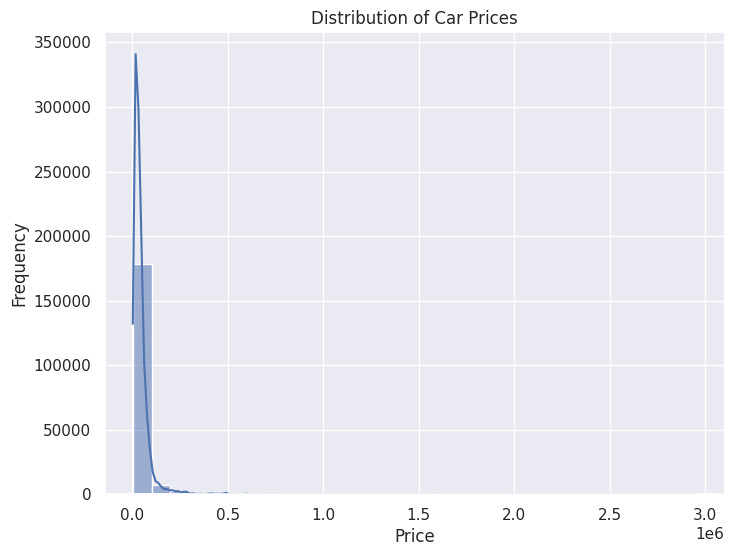

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

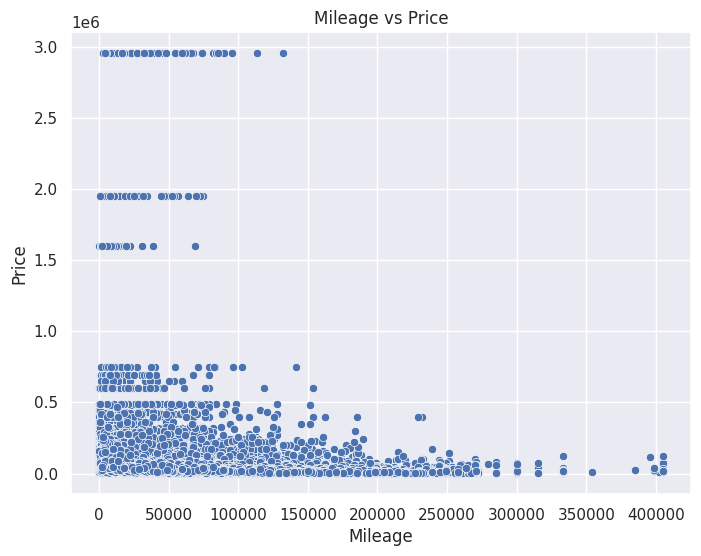

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='milage', y='price', data=df)
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

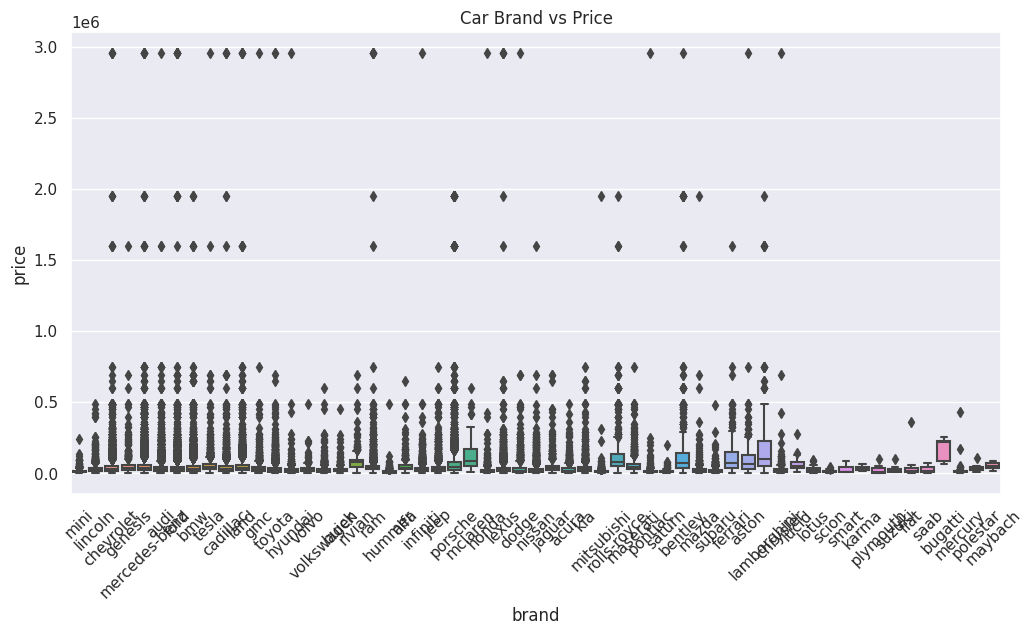

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price', data=df)
plt.title('Car Brand vs Price')
plt.xticks(rotation=45)
plt.show()


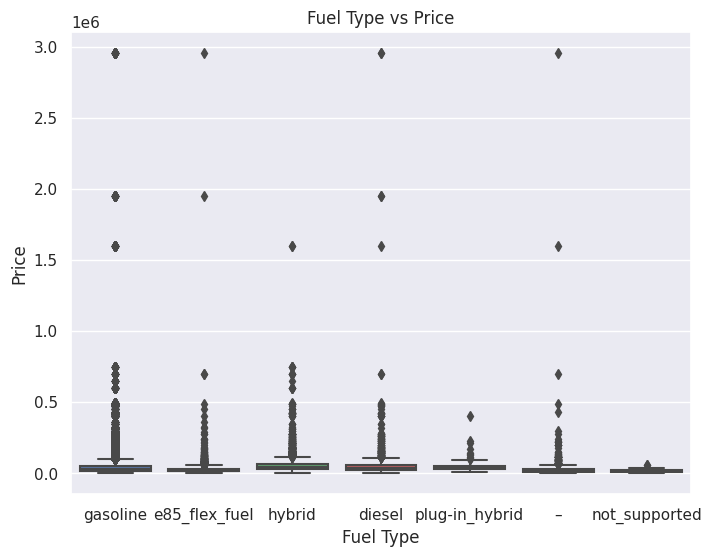

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='fuel_type', y='price', data=df)
plt.title('Fuel Type vs Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()


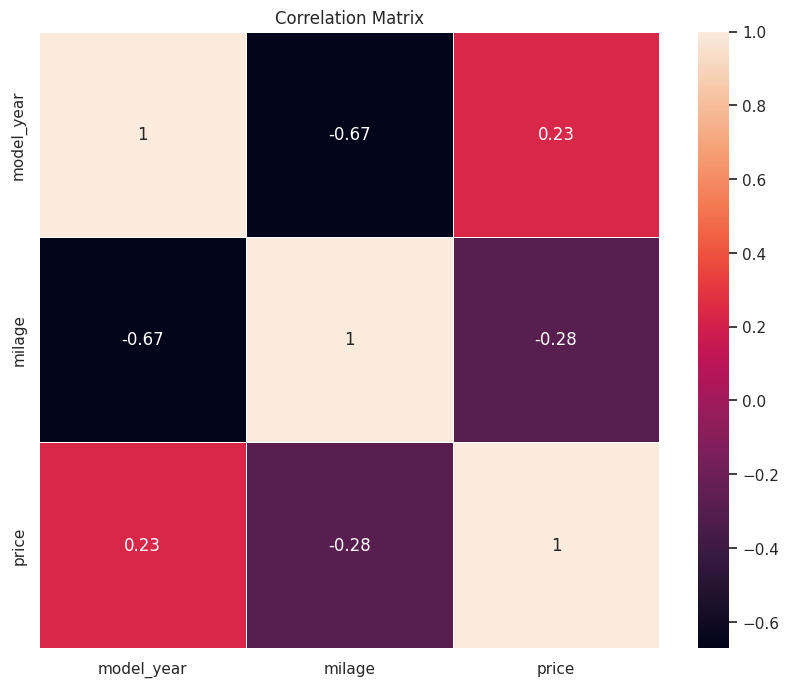

In [14]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(exclude='object').corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


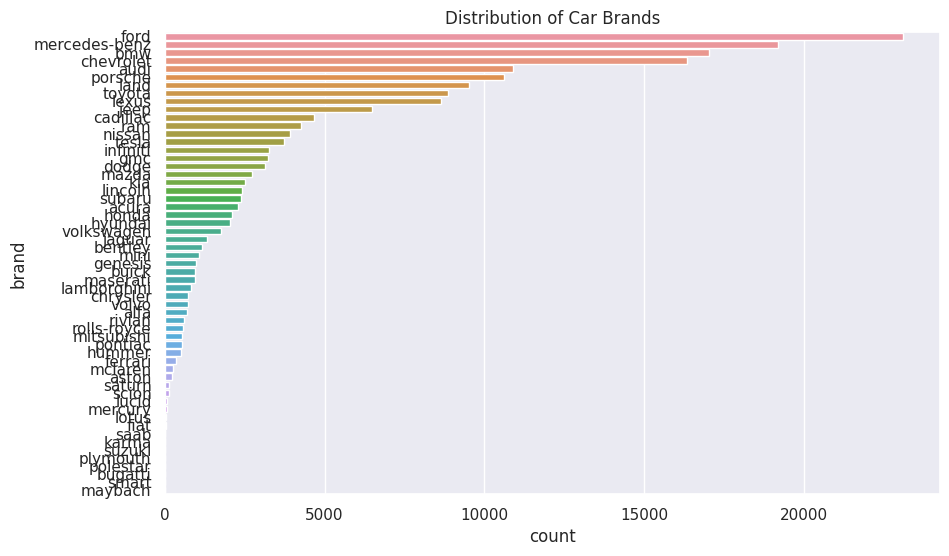

In [15]:
# Distribution of Brand
plt.figure(figsize=(10, 6))
sns.countplot(y='brand', data=df, order=df['brand'].value_counts().index)
plt.title('Distribution of Car Brands')
plt.show()

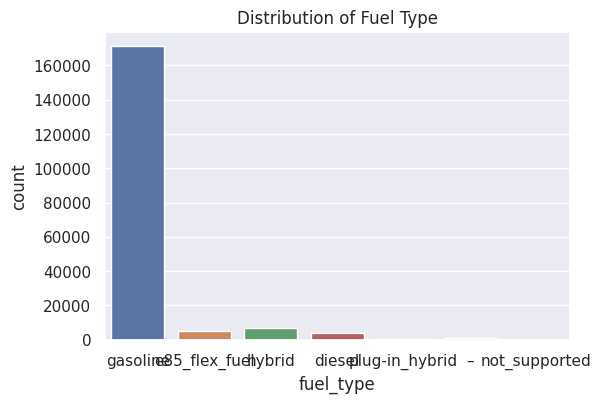

In [16]:
# Distribution of Fuel Type
plt.figure(figsize=(6, 4))
sns.countplot(x='fuel_type', data=df)
plt.title('Distribution of Fuel Type')
plt.show()

## 4. Feature Engineering


In [17]:
from sklearn.preprocessing import OrdinalEncoder

In [18]:
df['model_year']=df['model_year'].astype(object)
df_test['model_year']=df_test['model_year'].astype(object)

In [19]:
cat_cols = [col for col in df.select_dtypes('object').columns]

In [20]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
df[cat_cols]=encoder.fit_transform(df[cat_cols])
df_test[cat_cols]=encoder.transform(df_test[cat_cols])

In [21]:
x = df.drop('price',axis=1)

In [22]:
x_train , x_test , y_train , y_test = train_test_split(x,target,test_size=0.2,random_state=42) 

## 5. Model Building


In [23]:
# Example of training a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
rmse = mean_squared_error(y_test, y_pred,squared=False)
print(f'RootMean Squared Error: {rmse}')

RootMean Squared Error: 70255.42541440847


In [24]:
pred_sub = lr.predict(df_test)

In [25]:
sample_submission = pd.read_csv('../input/playground-series-s4e9/sample_submission.csv')
sample_submission['price'] = pred_sub
sample_submission.to_csv('lr_submission.csv', index=False)

In [26]:
import h2o
print(h2o.__version__)
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

3.46.0.4
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpantycnrx
  JVM stdout: /tmp/tmpantycnrx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpantycnrx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_unknownUser_90xy7m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [27]:
# %%time
# train = h2o.import_file("../input/playground-series-s4e9/train.csv")
# test = h2o.import_file("../input/playground-series-s4e9/test.csv")

In [28]:
train = h2o.H2OFrame(df)
test = h2o.H2OFrame(df_test)
x = train.columns
y = 'price'
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [29]:
aml = H2OAutoML(max_runtime_secs = 3500, seed = 42, project_name = "cars_price")
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),26/107
# GBM base models (used / total),12/39
# XGBoost base models (used / total),14/60
# DeepLearning base models (used / total),0/5
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [30]:
lb = aml.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20240910_161844,72615.9,5.27306e+09,19325.3,nan,5.27306e+09
StackedEnsemble_BestOfFamily_4_AutoML_1_20240910_161844,72650.1,5.27803e+09,19394,0.54223,5.27803e+09
StackedEnsemble_AllModels_2_AutoML_1_20240910_161844,72705.8,5.28613e+09,19324.7,0.537993,5.28613e+09
GBM_grid_1_AutoML_1_20240910_161844_model_7,72715.3,5.28751e+09,19532.5,0.554039,5.28751e+09
StackedEnsemble_AllModels_1_AutoML_1_20240910_161844,72716.5,5.28768e+09,19337.6,nan,5.28768e+09
GBM_grid_1_AutoML_1_20240910_161844_model_6,72728.7,5.28947e+09,19391.6,0.547433,5.28947e+09
StackedEnsemble_BestOfFamily_3_AutoML_1_20240910_161844,72742.2,5.29143e+09,19364.8,nan,5.29143e+09
GBM_grid_1_AutoML_1_20240910_161844_model_18,72749.2,5.29244e+09,19499.4,nan,5.29244e+09
GBM_grid_1_AutoML_1_20240910_161844_model_22,72769.1,5.29534e+09,19506.4,nan,5.29534e+09
StackedEnsemble_BestOfFamily_2_AutoML_1_20240910_161844,72794.1,5.29898e+09,19452.8,nan,5.29898e+09


In [31]:
# The leader model is stored here
aml.leader

key,value
Stacking strategy,cross_validation
Number of base models (used / total),26/107
# GBM base models (used / total),12/39
# XGBoost base models (used / total),14/60
# DeepLearning base models (used / total),0/5
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [32]:
pred = aml.predict(test)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
16677.1
83136.7
58262.5
24147.3
28601.7
16266
13169.9
42996.9
84533.9
32117.2


In [33]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

'/kaggle/working/product_backorders_model_bin/StackedEnsemble_AllModels_3_AutoML_1_20240910_161844'

In [34]:
sample_submission = pd.read_csv('../input/playground-series-s4e9/sample_submission.csv')
sample_submission.shape

(125690, 2)

In [35]:
sample_submission['price'] = pred.as_data_frame().values
sample_submission.to_csv('h2o_automl_submission.csv', index=False)

/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [36]:
h2o.save_model(aml.leader, path = "submission1.csv")

'/kaggle/working/submission1.csv/StackedEnsemble_AllModels_3_AutoML_1_20240910_161844'

In [37]:
sample_submission.head()

,id,price
0,188533,16677.056040
1,188534,83136.745805
2,188535,58262.506742
3,188536,24147.261420
4,188537,28601.690210
